In [1]:
!pip install numpy opencv-python matplotlib scipy
!pip install tqdm
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import dct, idct
import zipfile
import urllib.request
import os
from PIL import Image
import io


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# URL of the COIL-20 dataset
url = "https://cave.cs.columbia.edu/old/databases/SLAM_coil-20_coil-100/coil-20/coil-20-unproc.zip"

# Download the dataset
zip_path, _ = urllib.request.urlretrieve(url)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("coil-20")

# Check contents of the unzipped folder
print("Extracted files:", os.listdir("coil-20"))

Extracted files: ['coil-20-unproc']


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Load images from the dataset folder
images = load_images_from_folder("coil-20/coil-20-unproc")


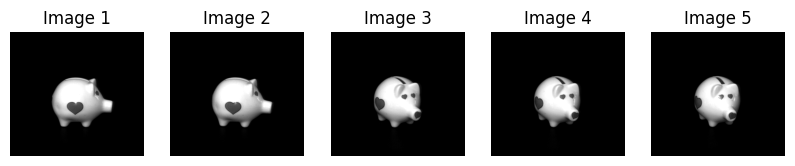

In [4]:
# Display some of the images
def display_images(images, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Image {i + 1}")
    plt.show()

# Display the first 5 images from the dataset
display_images(images, num_images=5)

In [5]:
#  RMSE Calculation
def calculate_rmse(original, reconstructed):
    return np.sqrt(((original - reconstructed) ** 2).mean())


In [6]:
# Implementing 2D-DCT
def dct_2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct_2d(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def process_blocks(image, block_size=8):
    h, w = image.shape
    dct_blocks = np.zeros((h, w), dtype=np.float32)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_blocks[i:i+block_size, j:j+block_size] = dct_2d(block)
    return dct_blocks

In [7]:
def get_quantization_matrix(quality):
    Q50 = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality
    return np.clip((Q50 * scale + 50) / 100, 1, None)

def quantize(block, quant_matrix):
    return np.round(block / quant_matrix)

def dequantize(block, quant_matrix):
    return block * quant_matrix


In [8]:
class Node:
    def __init__(self, freq, symbol, left=None, right=None):
        # frequency of the symbol
        self.freq = freq
        # symbol name (character)
        self.symbol = symbol
        # node left of current node
        self.left = left
        # node right of current node
        self.right = right
        # tree direction (0/1)
        self.huff = ''

# Utility function to print huffman codes
def print_codes(node, val=''):
    # huffman code for current node
    newVal = val + str(node.huff)

    # if node is not an edge node
    # then traverse inside it
    if node.left:
        print_codes(node.left, newVal)
    if node.right:
        print_codes(node.right, newVal)

    # if node is edge node then
    # display its huffman code
    if not node.left and not node.right:
        print(f"{node.symbol} -> {newVal}")

# characters for huffman tree
def create_tree(frequencies):
    nodes = []

    # converting characters and frequencies
    # into huffman tree nodes
    for symbol in frequencies:
        nodes.append(Node(frequencies[symbol], symbol))

    while len(nodes) > 1:
        # sort all the nodes in ascending order
        # based on their frequency
        nodes = sorted(nodes, key=lambda x: x.freq)

        # pick 2 smallest nodes
        left = nodes[0]
        right = nodes[1]

        # assign directional value to these nodes
        left.huff = 0
        right.huff = 1

        # combine the 2 smallest nodes to create
        # new node as their parent
        newNode = Node(left.freq + right.freq, left.symbol + right.symbol, left, right)

        # remove the 2 nodes and add their
        # parent as new node among others
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(newNode)

    return nodes[0]

def huffman_encoding(data):
    # Calculate frequency of each symbol
    frequency = {char: data.count(char) for char in set(data)}

    # Create Huffman Tree
    huffman_tree = create_tree(frequency)

    # Generate codes
    codes = {}
    generate_codes(huffman_tree, "", codes)

    # Encode the data
    encoded_data = "".join([codes[char] for char in data])
    return encoded_data, codes, huffman_tree

def generate_codes(node, current_code, codes):
    if node is not None:
        # Only assign codes to leaf nodes
        if (node.left is None) and (node.right is None):
            codes[node.symbol] = current_code

        generate_codes(node.left, current_code + "0", codes)
        generate_codes(node.right, current_code + "1", codes)


In [9]:
def huffman_decoding(encoded_data, codes):
    reverse_codes = {v: k for k, v in codes.items()}
    current_code = ""
    decoded_output = []

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_codes:
            symbol = reverse_codes[current_code]
            decoded_output.append(symbol)
            current_code = ""

    return ''.join(decoded_output)


In [10]:
def process_image(image, quality):
    block_size = 8
    quant_matrix = get_quantization_matrix(quality)
    # print(f"Quant Matrix for Quality {quality}:\n{quant_matrix}")
    h, w = image.shape
    processed_image = np.zeros((h, w), dtype=np.float32)
    total_encoded_bits = 0

    # Prepare for Huffman coding across entire image
    all_symbols = []

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct_2d(block)
            quantized_block = quantize(dct_block, quant_matrix)

            # Flatten and normalize quantized block for symbol conversion
            flat_block = quantized_block.flatten()

            # Clip the values before converting to characters
            symbols = [chr(int(np.clip(code + 128, 0, 0x10FFFF))) for code in flat_block]

            '''
            I've added np.clip(code + 128, 0, 0x10FFFF) inside the chr() function.
            This ensures that the value passed to chr() is within the acceptable range (0 to 0x10FFFF).
            If the value is below 0, it's clipped to 0; if it's above 0x10FFFF, it's clipped to 0x10FFFF.
            This is to prevent the ValueError: chr() arg not in range(0x110000)
            '''
            all_symbols.extend(symbols)

    # Huffman encode/decode entire image's symbols for better compression
    encoded_data, codes, tree = huffman_encoding(''.join(all_symbols))
    total_encoded_bits += len(encoded_data)

    # Decode symbols
    decoded_symbols = huffman_decoding(encoded_data, codes)
    decoded_symbols = [ord(char) - 128 for char in decoded_symbols]

    # # After Huffman encoding/decoding
    # print(f"Sample Symbols: {all_symbols[:100]}")  # print sample of first 100 symbols
    # print(f"Encoded Data: {encoded_data[:100]}")  # print sample of first 100 encoded data
    # print(f"Decoded Symbols: {decoded_symbols[:100]}")  # print sample of first 100 decoded symbols

    # Place decoded blocks back into image
    symbol_index = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block_size_flat = block_size * block_size
            decoded_block = np.array(decoded_symbols[symbol_index:symbol_index + block_size_flat])
            decoded_block = decoded_block.reshape(block_size, block_size)
            symbol_index += block_size_flat

            dequantized_block = dequantize(decoded_block, quant_matrix)
            idct_block = idct_2d(dequantized_block)
            processed_image[i:i+block_size, j:j+block_size] = idct_block

    return processed_image, total_encoded_bits

Processing for quality 10


Processing quality 10: 100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


Processing for quality 20


Processing quality 20: 100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


Processing for quality 30


Processing quality 30: 100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


Processing for quality 40


Processing quality 40: 100%|██████████| 25/25 [00:41<00:00,  1.66s/it]


Processing for quality 50


Processing quality 50: 100%|██████████| 25/25 [00:43<00:00,  1.74s/it]


Processing for quality 60


Processing quality 60: 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


Processing for quality 70


Processing quality 70: 100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


Processing for quality 80


Processing quality 80: 100%|██████████| 25/25 [00:43<00:00,  1.76s/it]


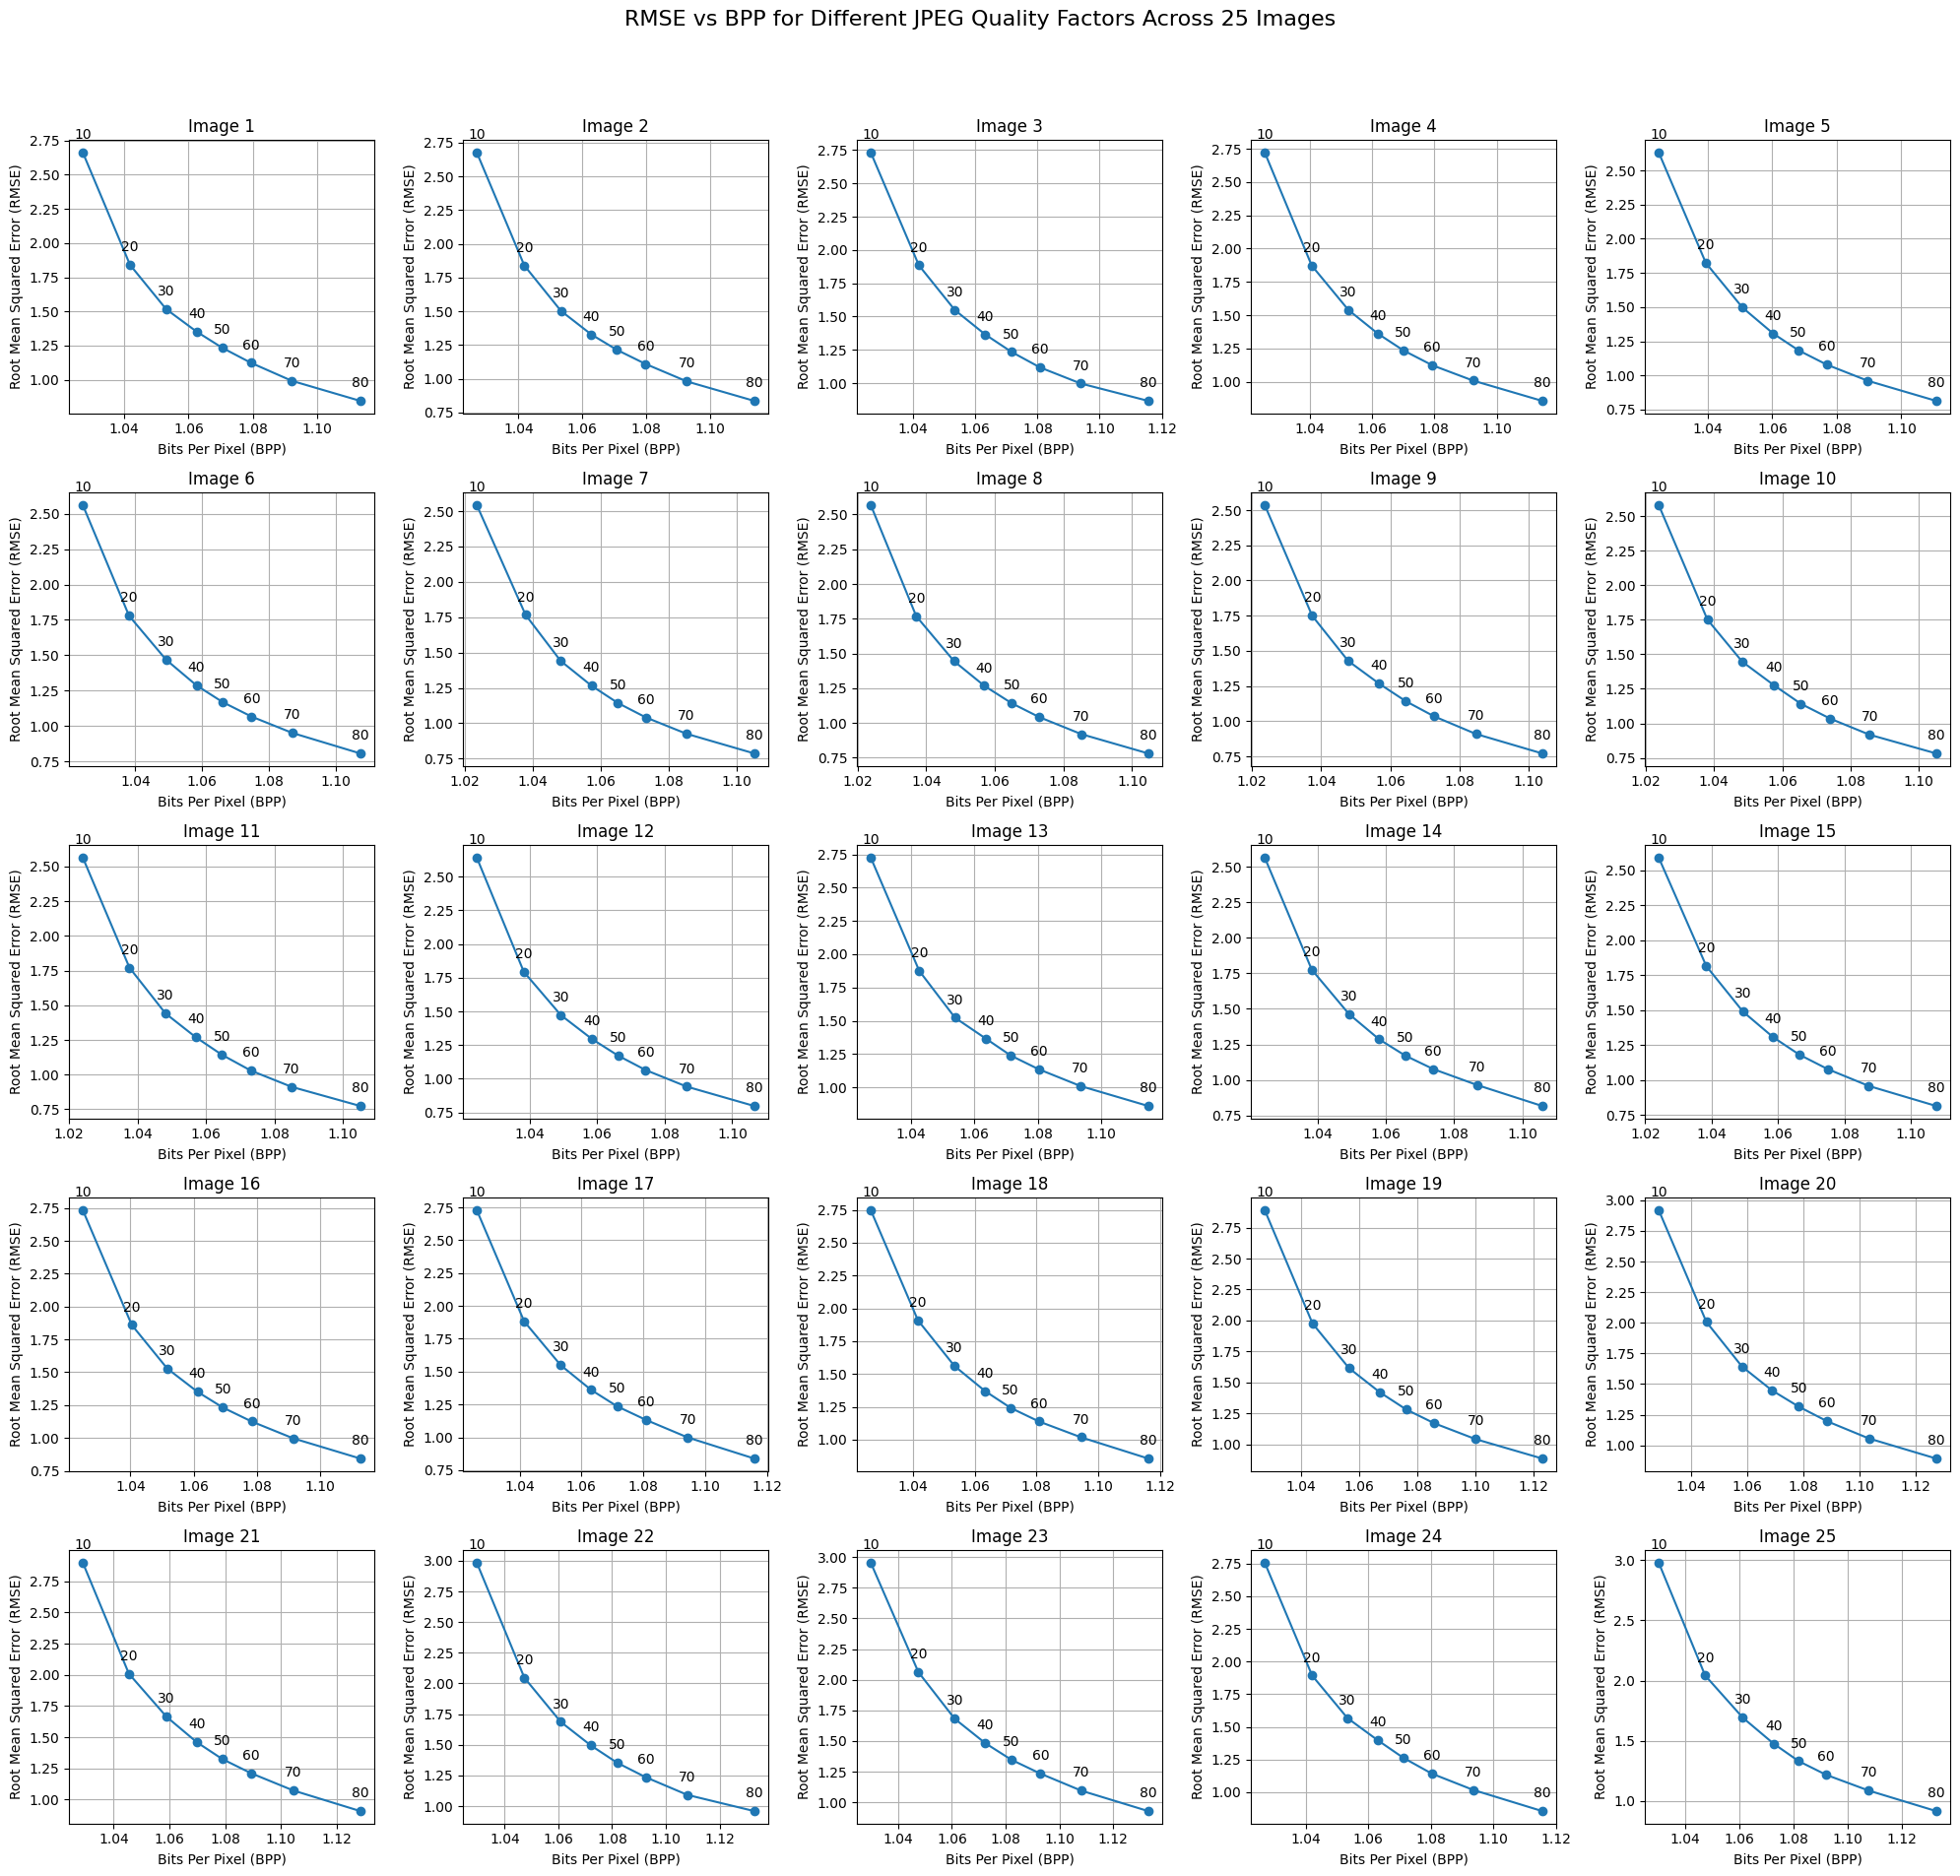

In [11]:
images_to_process = images[:25]  # Only the first 25 images
quality_factors = range(10, 90, 10)  # Quality factors from 10 to 90
individual_rmse_values = [[] for _ in range(len(images_to_process))]  # List of lists to hold RMSE for each image
individual_bpp_values = [[] for _ in range(len(images_to_process))]  # List of lists to hold BPP for each image

# Iterate over quality factors
for quality in quality_factors:
    print(f"Processing for quality {quality}")
    for i, image in enumerate(tqdm(images_to_process, desc=f"Processing quality {quality}")):
        processed_image, total_encoded_bits = process_image(image, quality)
        rmse = calculate_rmse(image, processed_image)
        bpp = total_encoded_bits / (image.shape[0] * image.shape[1])

        # Append RMSE and BPP to their respective lists
        individual_rmse_values[i].append(rmse)
        individual_bpp_values[i].append(bpp)

# Plot RMSE vs BPP for each image
fig, axs = plt.subplots(5, 5, figsize=(20, 20))  # Adjust subplot grid as needed
fig.suptitle('RMSE vs BPP for Different JPEG Quality Factors Across 25 Images', fontsize=16)
axs = axs.flatten()  # Flatten the array of axes to make iterating easier

for i in range(len(images_to_process)):
    axs[i].plot(individual_bpp_values[i], individual_rmse_values[i], marker='o')
    axs[i].set_xlabel('Bits Per Pixel (BPP)')
    axs[i].set_ylabel('Root Mean Squared Error (RMSE)')
    axs[i].set_title(f'Image {i+1}')
    axs[i].grid(True)

    # Annotate each point with its corresponding quality factor
    for j, quality in enumerate(quality_factors):
        axs[i].annotate(quality, (individual_bpp_values[i][j], individual_rmse_values[i][j]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the global title
plt.show()


In [12]:
def save_image_to_buffer(image):
    """ Saves an image to a BytesIO buffer and returns the buffer. """
    image_pil = Image.fromarray(np.uint8(image))
    buf = io.BytesIO()
    image_pil.save(buf, format='JPEG')  # Change to 'PNG' for lossless compression
    buf.seek(0)  # Rewind the buffer to beginning
    return buf

def get_image_size(image):
    """ Returns the size of the image saved to a buffer. """
    buf = save_image_to_buffer(image)
    size = buf.getbuffer().nbytes  # Get the number of bytes in buffer
    return size

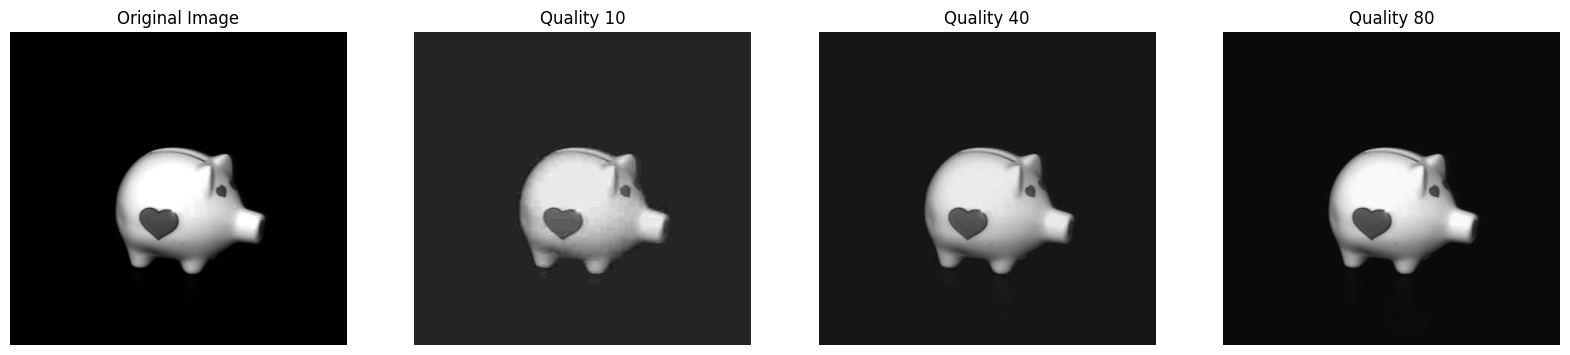

In [13]:
# Load an example image
example_index = 23  # Change index to choose different image
original_image = images[example_index]

# Process the image at different quality factors
quality_factors = [10, 40, 80]
compressed_images = []
sizes = []

for quality in quality_factors:
    processed_image, _ = process_image(original_image, quality)
    compressed_images.append(processed_image)
    sizes.append(get_image_size(processed_image))

# Size of the original image
original_size = get_image_size(original_image)

# Display original and compressed images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

for i, img in enumerate(compressed_images):
    axs[i+1].imshow(img, cmap='gray')
    axs[i+1].set_title(f'Quality {quality_factors[i]}')
    axs[i+1].axis('off')

plt.show()

In [14]:
# Report sizes and compression rates
print(f"Original Image Size: {original_size} bytes")
for i, size in enumerate(sizes):
    compression_rate = original_size / size
    print(f"Compressed Image Size at Quality {quality_factors[i]}: {size} bytes, Compression Rate: {compression_rate:.2f}")

Original Image Size: 5388 bytes
Compressed Image Size at Quality 10: 5767 bytes, Compression Rate: 0.93
Compressed Image Size at Quality 40: 7324 bytes, Compression Rate: 0.74
Compressed Image Size at Quality 80: 8105 bytes, Compression Rate: 0.66


<h3 align="left"><font color='#C499F3'>❗PROBLEM❗ </font></h3>

The results we're observing where the "compressed" image sizes are larger than the original could indeed be due to the overhead introduced by the JPEG file format when saved using Python's PIL library. JPEG, by its nature, includes additional metadata and possibly a minimum block size that could cause even a "compressed" image to increase in size when the original data is already small or when the image complexity is low. This effect is more pronounced at higher quality factors where less compression is applied.

Additionally, using a format like JPEG for demonstrating the effects of custom compression algorithms can be misleading because JPEG itself applies its own compression techniques (including DCT, quantization similar to what you're applying, and Huffman coding)

===================================================================================================================

<h3 align="left"><font color='#C499F3'>💡 SOLUTION </font></h3>

To accurately measure the effects of your custom DCT and Huffman compression, consider using a raw binary format or a simple format like PPM for image data, which does not apply any additional compression, to store the image data after compression. Since Python's PIL does not support raw binary data directly in a way that would benefit this use case, we will skip saving the files and instead measure the effective data size directly from the data produced by your compression steps.

#### Modify Huffman Encoding to Return Bit String Lengths
Instead of simulating file saving, you can modify the Huffman encoding to return the length of the encoded data in bits and use this for your size calculations. This will give a more accurate measure of how much data is actually needed to represent the compressed image.

```
def huffman_encode(data):
    """ Encodes data using Huffman coding and returns the encoded data and its bit length. """
    frequency = {char: data.count(char) for char in set(data)}
    huffman_tree = create_tree(frequency)
    codes = {}
    generate_codes(huffman_tree, "", codes)
    encoded_data = ''.join(codes[char] for char in data)
    total_bits = sum(len(codes[char]) for char in data)  # Calculate total bits used
    return encoded_data, total_bits

```



In [15]:
def huffman_encode(data):
    """ Encodes data using Huffman coding and returns the encoded data and its bit length. """
    # Calculate frequency of each symbol
    frequency = {char: data.count(char) for char in set(data)}
    huffman_tree = create_tree(frequency)
    codes = {}
    generate_codes(huffman_tree, "", codes)
    encoded_data = ''.join(codes[char] for char in data)
    total_bits = sum(len(codes[char]) for char in data)  # Calculate total bits used
    return encoded_data, total_bits

### Simulate Compression without Saving
Now, update your processing function to use this new method of Huffman encoding and adjust how the compression rate is calculated based on the number of bits rather than file size.

In [16]:
def process_image(image, quality):
    block_size = 8
    quant_matrix = get_quantization_matrix(quality)
    h, w = image.shape
    total_bits = 0

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct_2d(block)
            quantized_block = quantize(dct_block, quant_matrix)
            flat_block = quantized_block.flatten()
            symbols = ''.join(chr(int(code) + 128) for code in flat_block)
            _, bits_used = huffman_encode(symbols)
            total_bits += bits_used

    return total_bits / 8  # Convert bits to bytes for consistency


In [17]:
original_bytes = np.product(original_image.shape)
print(f"Original Image Size: {original_bytes} bytes")

for quality in [10, 40, 80]:
    compressed_bytes = process_image(original_image, quality)
    compression_rate = original_bytes / compressed_bytes
    print(f"Compressed Data Size at Quality {quality}: {compressed_bytes:.2f} bytes, Compression Rate: {compression_rate:.2f}")


Original Image Size: 186368 bytes
Compressed Data Size at Quality 10: 3548.00 bytes, Compression Rate: 52.53
Compressed Data Size at Quality 40: 4246.50 bytes, Compression Rate: 43.89
Compressed Data Size at Quality 80: 5377.50 bytes, Compression Rate: 34.66
